# Traitement et Analyse de Données EELS-SPIM

Ce notebook présente un flux de travail complet pour le traitement et l'analyse de données de spectroscopie de perte d'énergie d'électrons (EELS) acquises en mode image-spectre (SPIM).

Le processus inclut les étapes suivantes :
1.  **Chargement et Prétraitement** : Importation des données et suppression des artefacts liés aux détecteurs.
2.  **Analyse en Composantes Principales (ACP/PCA)** : Réduction du bruit et extraction des principales sources de variance.
3.  **Déconvolution de Richardson-Lucy** : Amélioration de la résolution énergétique par déconvolution avec le pic de non-perte d'énergie (ZLP).
4.  **Réduction de Dimensionnalité avec UMAP** : Projection des données dans un espace de faible dimension pour la visualisation et le clustering.
5.  **Clustering et Analyse** : Segmentation des données avec K-Means, raffinement optionnel avec SVM, et analyse des spectres moyens de chaque classe.

## 1. Importations et Configuration

In [1]:
# Configuration de l'affichage des graphiques dans le notebook (facultatif)
%matplotlib inline

# Importations des bibliothèques nécessaires
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Outils de traitement du signal et d'image
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter, median_filter

# Algorithmes de Machine Learning
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [7]:
# --- Paramètres de l'analyse ---

# Identifiants de l'acquisition
TRANSITION_NUMBER = "t8"
FRAME_NUMBER = '6026-6226'

# Fichiers d'entrée et de sortie (noms générés automatiquement)
INPUT_FILE = f"spim_{TRANSITION_NUMBER}_{FRAME_NUMBER}-cut.dm4"
ZLP_FILE = "Spectrum_from_spim01-vacuum-CTS-2ms-200x68px-cut-removed_spikes-(aligned)_PCA0to7-recut1018.dm4"

# Paramètres pour la PCA
N_PCA_COMPONENTS = 5

# Paramètres pour la déconvolution Richardson-Lucy
RL_ITERATIONS = 1

# Paramètres pour UMAP
UMAP_N_NEIGHBORS = 15
UMAP_MIN_DIST = 0.00001
UMAP_METRIC = 'correlation'
UMAP_SPREAD = 1.0

# Paramètres pour le Clustering
N_CLUSTERS = 5

## 2. Prétraitement : Suppression des Artefacts

In [5]:
print(f"Chargement du fichier : {INPUT_FILE}")
s = hs.load(INPUT_FILE, stack=True)

# Canaux spécifiques où les "spikes" apparaissent (frontières des détecteurs TIMEPIX)
channels_to_adjust = [(255, 256), (511, 512), (767, 768)]
reduction_ratio = 1.8

print("Correction des artefacts aux jonctions des détecteurs...")
data = s.data.copy() # Travailler sur une copie pour éviter les modifications in-place non désirées

# Réduction de l'intensité sur les canaux spécifiés
for (start, end) in channels_to_adjust:
    # Assurer que les indices sont dans les bornes
    if start < data.shape[2] and end < data.shape[2]:
        data[:, :, start:end+1] /= reduction_ratio

s.data = data

# Sauvegarde du résultat
output_spikes_removed_file = f"spim_{TRANSITION_NUMBER}_{FRAME_NUMBER}-cut-preprocessed.rpl"
print(f"Sauvegarde des données prétraitées dans : {output_spikes_removed_file}")
s.save(output_spikes_removed_file, overwrite=True)

Chargement du fichier : spim_t8_6026-6226-cut.dm4
[########################################] | 100% Completed | 103.53 ms
Correction des artefacts aux jonctions des détecteurs...
Sauvegarde des données prétraitées dans : spim_t8_6026-6226-cut-preprocessed.rpl


## 3. Analyse en Composantes Principales (PCA)

[########################################] | 100% Completed | 121.26 ms
Calcul de la décomposition PCA...
Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None
Affichage du graphique de la variance expliquée (Scree Plot)...


Text(0.5, 0.98, 'Scree Plot - Variance Expliquée par Composante')

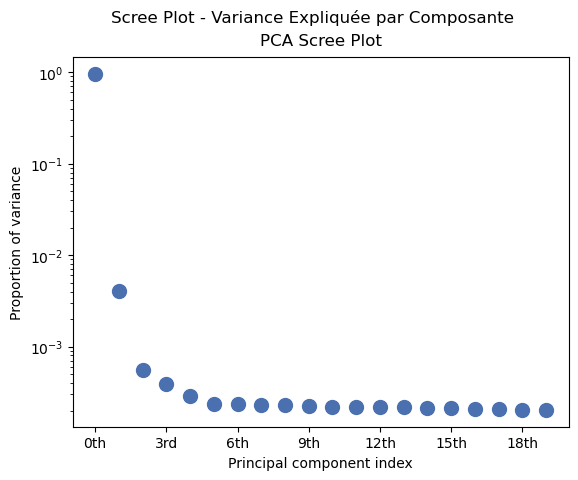

In [3]:
# Optionnel : si vous avez déjà aligné les données, chargez le fichier aligné.
# Pour cet exemple, nous continuons avec les données corrigées des spikes et alignées.
s = hs.load(f"spim_{TRANSITION_NUMBER}_{FRAME_NUMBER}-cut-preprocessed-(aligned).dm4", stack=True)

s.set_signal_type("EELS")

print("Calcul de la décomposition PCA...")
s.decomposition(True)

print("Affichage du graphique de la variance expliquée (Scree Plot)...")
s.plot_explained_variance_ratio(n=20)
plt.suptitle('Scree Plot - Variance Expliquée par Composante')

Affichage des facteurs de décomposition (spectres propres)...
Affichage des poids de décomposition (images des composantes)...


[<Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 3 Axes>,
 <Figure size 640x480 with 3 Axes>,
 <Figure size 640x480 with 3 Axes>,
 <Figure size 640x480 with 3 Axes>]

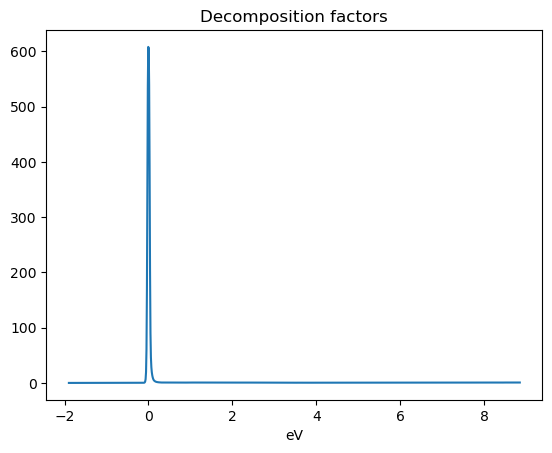

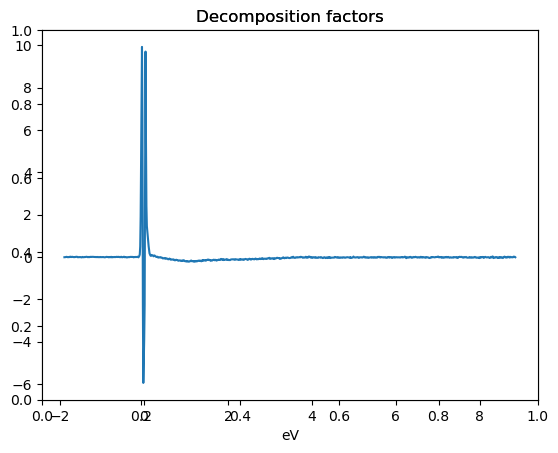

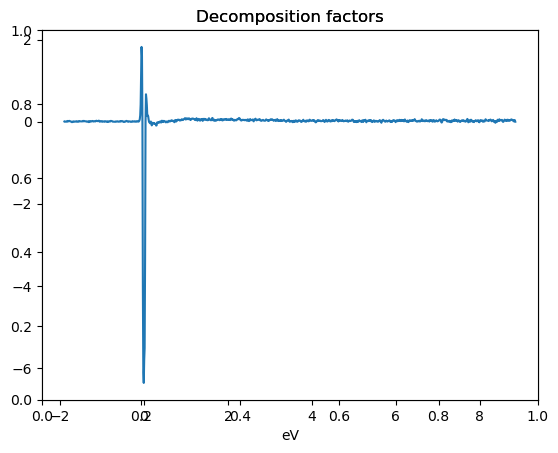

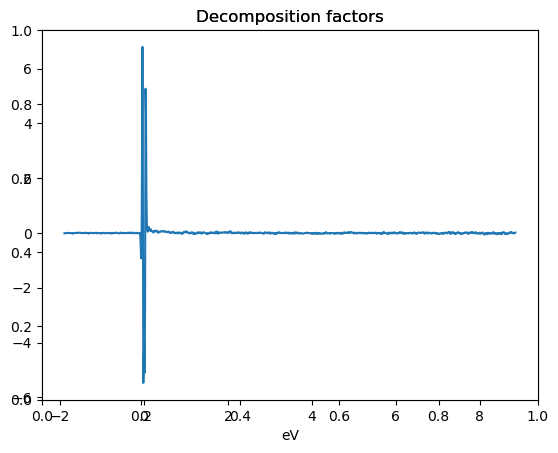

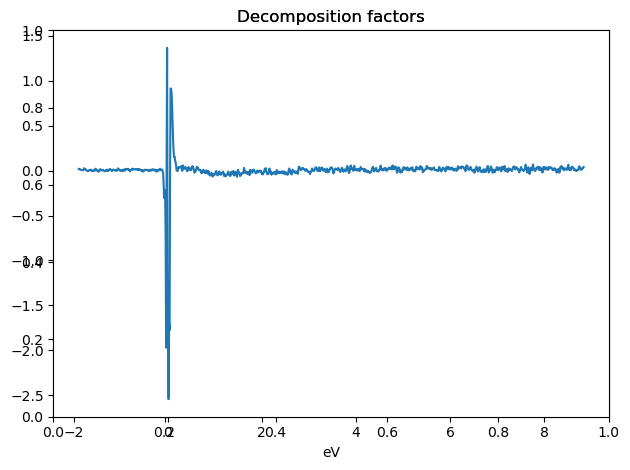

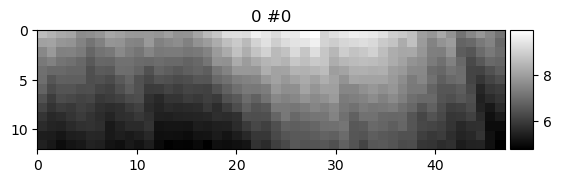

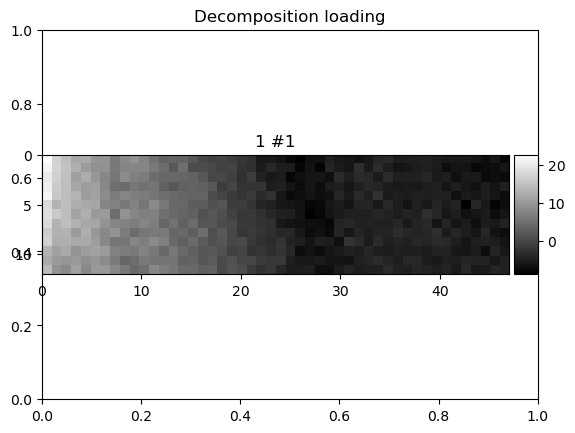

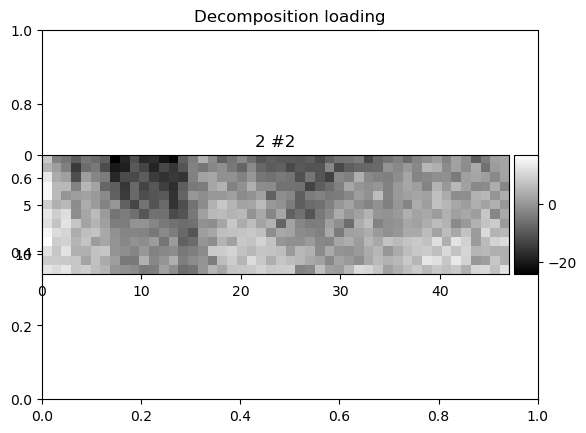

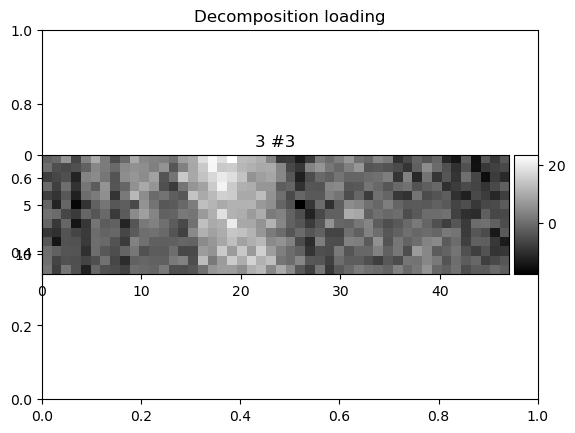

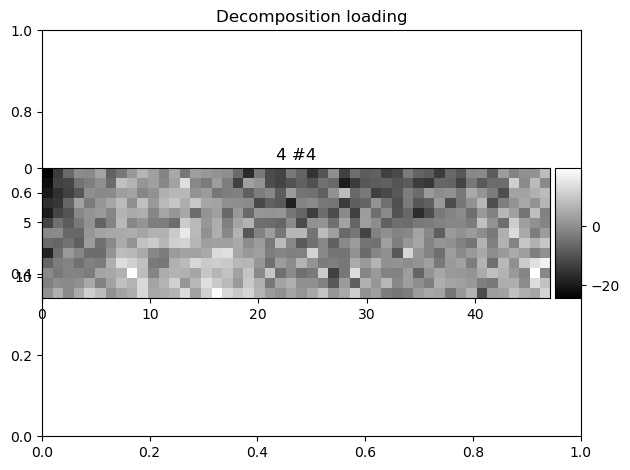

In [4]:
print("Affichage des facteurs de décomposition (spectres propres)...")
s.plot_decomposition_factors(N_PCA_COMPONENTS, same_window=False)

print("Affichage des poids de décomposition (images des composantes)...")
s.plot_decomposition_loadings(N_PCA_COMPONENTS, same_window=False)

In [5]:
print(f"Extraction des {N_PCA_COMPONENTS} premières composantes principales...")
s_pca = s.get_decomposition_model(N_PCA_COMPONENTS)

# Sauvegarde du résultat de la PCA
output_pca_file = f"spim_{TRANSITION_NUMBER}_{FRAME_NUMBER}-cut-preprocessed-(aligned)-pca{N_PCA_COMPONENTS-1}.rpl"
print(f"Sauvegarde des données après PCA dans : {output_pca_file}")
s_pca.save(output_pca_file, overwrite=True)

Extraction des 5 premières composantes principales...
Sauvegarde des données après PCA dans : spim_t8_6026-6226-cut-preprocessed-(aligned)-pca4.rpl


## 4. Déconvolution de Richardson-Lucy

In [8]:
print("Chargement du spectre ZLP...")
zlp = hs.load(ZLP_FILE, stack=False)
zlp.set_signal_type("EELS")

s_pca = hs.load(f"spim_{TRANSITION_NUMBER}_{FRAME_NUMBER}-cut-preprocessed-(aligned)-pca{N_PCA_COMPONENTS-1}-.dm4", stack=True)
s_pca.set_signal_type("EELS")

print(f"Application de la déconvolution Richardson-Lucy avec {RL_ITERATIONS} itérations...")
s_deconv = s_pca.richardson_lucy_deconvolution(zlp, iterations=RL_ITERATIONS)

# Sauvegarde du résultat
output_rlc_file = f"spim_{TRANSITION_NUMBER}_{FRAME_NUMBER}-cut-preprocessed-(aligned)-pca{N_PCA_COMPONENTS-1}-rlc{RL_ITERATIONS}.rpl"
print(f"Sauvegarde des données déconvoluées dans : {output_rlc_file}")
s_deconv.save(output_rlc_file, overwrite=True)

Chargement du spectre ZLP...
[########################################] | 100% Completed | 105.30 ms
Application de la déconvolution Richardson-Lucy avec 1 itérations...
[########################################] | 100% Completed | 513.16 ms
Sauvegarde des données déconvoluées dans : spim_t8_6026-6226-cut-preprocessed-(aligned)-pca4-rlc1.rpl


## 5. Réduction de Dimensionnalité avec UMAP

In [9]:
# Accès aux données déconvoluées
s_deconv = hs.load(f"spim_{TRANSITION_NUMBER}_{FRAME_NUMBER}-cut-preprocessed-(aligned)-pca{N_PCA_COMPONENTS-1}-rlc{RL_ITERATIONS}-.dm4", stack=True)
s_deconv.set_signal_type("EELS")

eels_data = s_deconv.data
height, width, spectra_length = eels_data.shape

# Aplatir les données (chaque pixel devient une ligne)
flattened_data = eels_data.reshape(height * width, spectra_length)

# --- Normalisation pour corriger les effets d'épaisseur ---
energy_axis = s_deconv.axes_manager.signal_axes[0].axis
low_loss_range = (0.5, 10)  # eV
low_loss_indices = np.where((energy_axis >= low_loss_range[0]) & (energy_axis <= low_loss_range[1]))[0]

integrated_intensity = np.sum(flattened_data[:, low_loss_indices], axis=1, keepdims=True)

# Éviter la division par zéro pour les pixels vides
integrated_intensity[integrated_intensity == 0] = 1 
normalized_data = flattened_data / integrated_intensity

# Standardisation des données (moyenne=0, variance=1)
scaler = StandardScaler()
standardized_data = scaler.fit_transform(normalized_data)

print("Calcul de la projection UMAP...")
umap_reducer = umap.UMAP(
    n_neighbors=UMAP_N_NEIGHBORS, 
    min_dist=UMAP_MIN_DIST, 
    n_components=2, 
    metric=UMAP_METRIC, 
    spread=UMAP_SPREAD,
    random_state=42
)
umap_embedding = umap_reducer.fit_transform(standardized_data)

[########################################] | 100% Completed | 106.12 ms
Calcul de la projection UMAP...


C:\Users\khelfa\AppData\Local\anaconda3\envs\TEST-3--13-12-2024\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


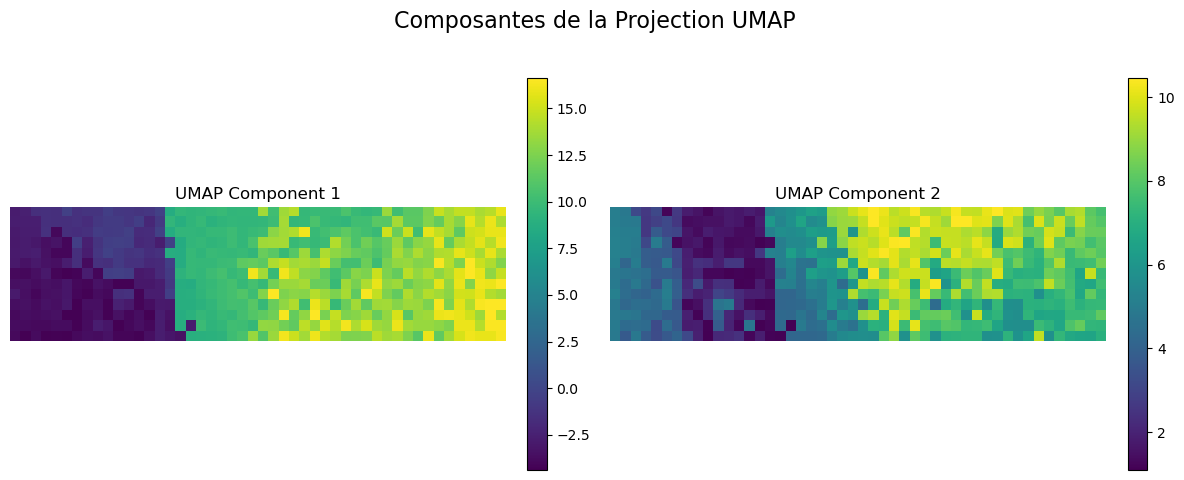

In [10]:
# Visualisation des composantes UMAP
umap_embedding_reshaped = umap_embedding.reshape(height, width, 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Composantes de la Projection UMAP', fontsize=16)

im1 = ax1.imshow(umap_embedding_reshaped[:, :, 0], cmap='viridis')
ax1.set_title('UMAP Component 1')
ax1.axis('off')
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

im2 = ax2.imshow(umap_embedding_reshaped[:, :, 1], cmap='viridis')
ax2.set_title('UMAP Component 2')
ax2.axis('off')
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 6. Clustering et Analyse des Spectres

### 6.1. Clustering avec K-Means

In [11]:
print(f"Exécution du clustering K-Means avec {N_CLUSTERS} clusters...")
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(umap_embedding)
print("Clustering terminé.")

Exécution du clustering K-Means avec 5 clusters...
Clustering terminé.


C:\Users\khelfa\AppData\Local\anaconda3\envs\TEST-3--13-12-2024\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Analyse des 5 clusters (K-Means)...


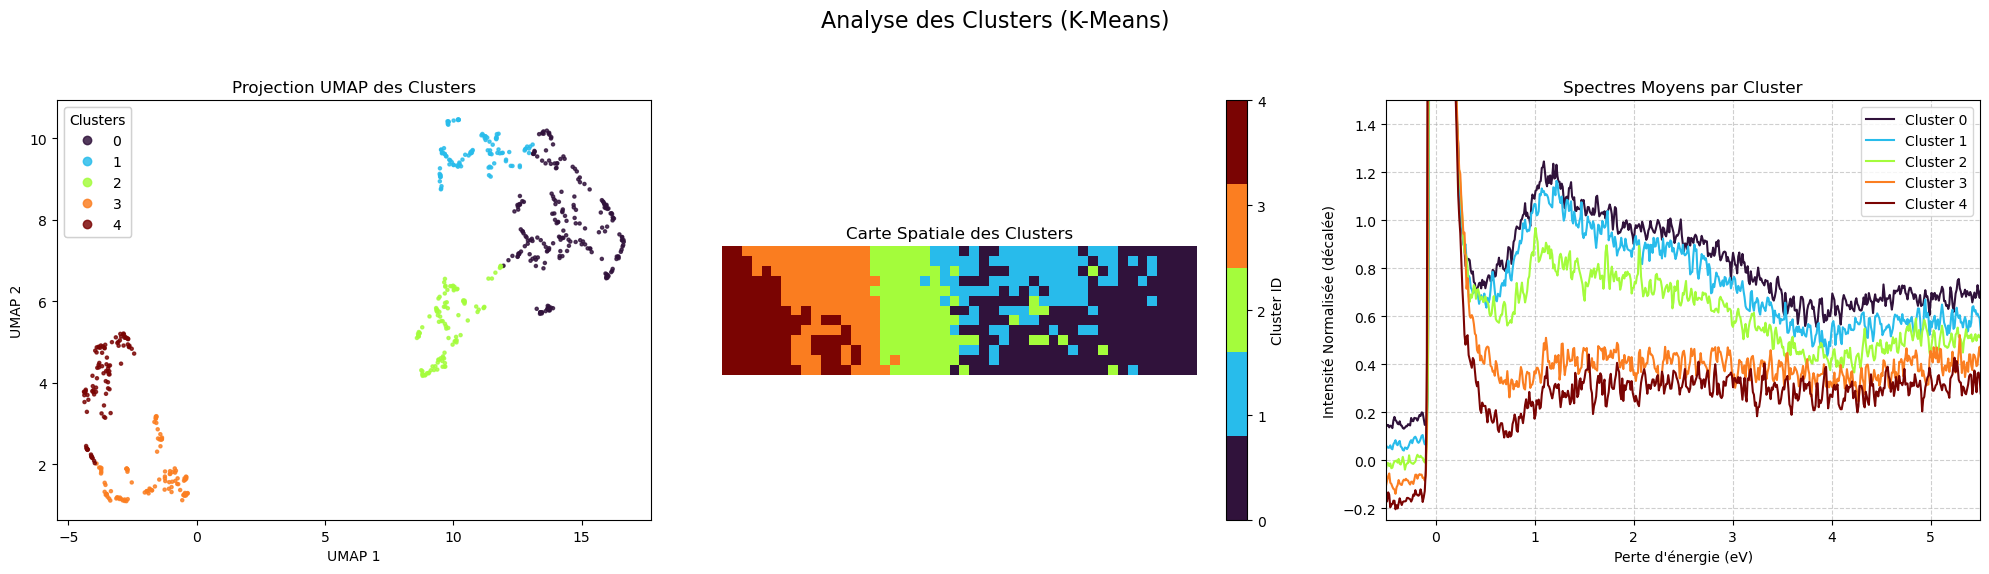

In [13]:
def analyze_and_plot_clusters(labels, title_suffix):
    """
    Fonction pour sommer, normaliser, trier et afficher les spectres des clusters.
    Affiche également la projection UMAP et la carte des clusters.
    """
    n_unique_clusters = len(np.unique(labels))
    print(f"Analyse des {n_unique_clusters} clusters ({title_suffix})...")

    # Sommation des spectres par cluster
    summed_spectra = np.zeros((n_unique_clusters, spectra_length))
    for i in range(n_unique_clusters):
        cluster_indices = np.where(labels == i)[0]
        if len(cluster_indices) > 0:
            summed_spectra[i] = np.sum(flattened_data[cluster_indices], axis=0)

    # Normalisation des spectres (par exemple, entre 6 et 8 eV)
    eV_range = (6, 8)
    eV_indices = np.where((energy_axis >= eV_range[0]) & (energy_axis <= eV_range[1]))[0]
    max_intensity = np.max(summed_spectra[:, eV_indices], axis=1, keepdims=True)
    max_intensity[max_intensity == 0] = 1 # Éviter la division par zéro
    normalized_spectra = summed_spectra / max_intensity

    # Tri des clusters en fonction de l'intensité à un point d'énergie spécifique (ex: 1.15 eV)
    eV_sort_point = 1.15
    eV_index = np.argmin(np.abs(energy_axis - eV_sort_point))
    intensities_at_point = normalized_spectra[:, eV_index]
    sorted_indices = np.argsort(intensities_at_point)[::-1] # Tri descendant
    
    # Création d'une table de correspondance pour les labels triés
    label_remap = {old_label: new_label for new_label, old_label in enumerate(sorted_indices)}
    sorted_labels = np.array([label_remap[l] for l in labels])
    sorted_normalized_spectra = normalized_spectra[sorted_indices]

    # --- Visualisations ---
    colormap = plt.get_cmap('turbo', n_unique_clusters)

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(f"Analyse des Clusters ({title_suffix})", fontsize=16)

    # 1. Projection UMAP colorée par cluster
    scatter = axes[0].scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=sorted_labels, s=5, alpha=0.8, cmap=colormap)
    axes[0].set_title('Projection UMAP des Clusters')
    axes[0].set_xlabel('UMAP 1')
    axes[0].set_ylabel('UMAP 2')
    legend1 = axes[0].legend(*scatter.legend_elements(), title="Clusters")
    axes[0].add_artist(legend1)

    # 2. Carte spatiale des clusters
    cluster_map = sorted_labels.reshape(height, width)
    im = axes[1].imshow(cluster_map, cmap=colormap)
    axes[1].set_title('Carte Spatiale des Clusters')
    axes[1].axis('off')
    fig.colorbar(im, ax=axes[1], ticks=range(n_unique_clusters), label='Cluster ID')

    # 3. Spectres moyens normalisés et décalés
    offset = -0.08
    for i in range(n_unique_clusters):
        axes[2].plot(energy_axis, sorted_normalized_spectra[i] + i * offset, color=colormap(i), label=f'Cluster {i}')
    axes[2].set_title('Spectres Moyens par Cluster')
    axes[2].set_xlim(-0.5, 5.5)
    axes[2].set_ylim(-0.25, 1.5)
    axes[2].set_xlabel("Perte d'énergie (eV)")
    axes[2].set_ylabel('Intensité Normalisée (décalée)')
    axes[2].legend()
    axes[2].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Lancer l'analyse pour les labels K-Means
analyze_and_plot_clusters(kmeans_labels, "K-Means")

### 6.2. Raffinement des Clusters avec SVM (Optionnel)

Entraînement du classificateur SVM...
Précision de la classification SVM : 96.00%
Analyse des 5 clusters (K-Means + SVM)...


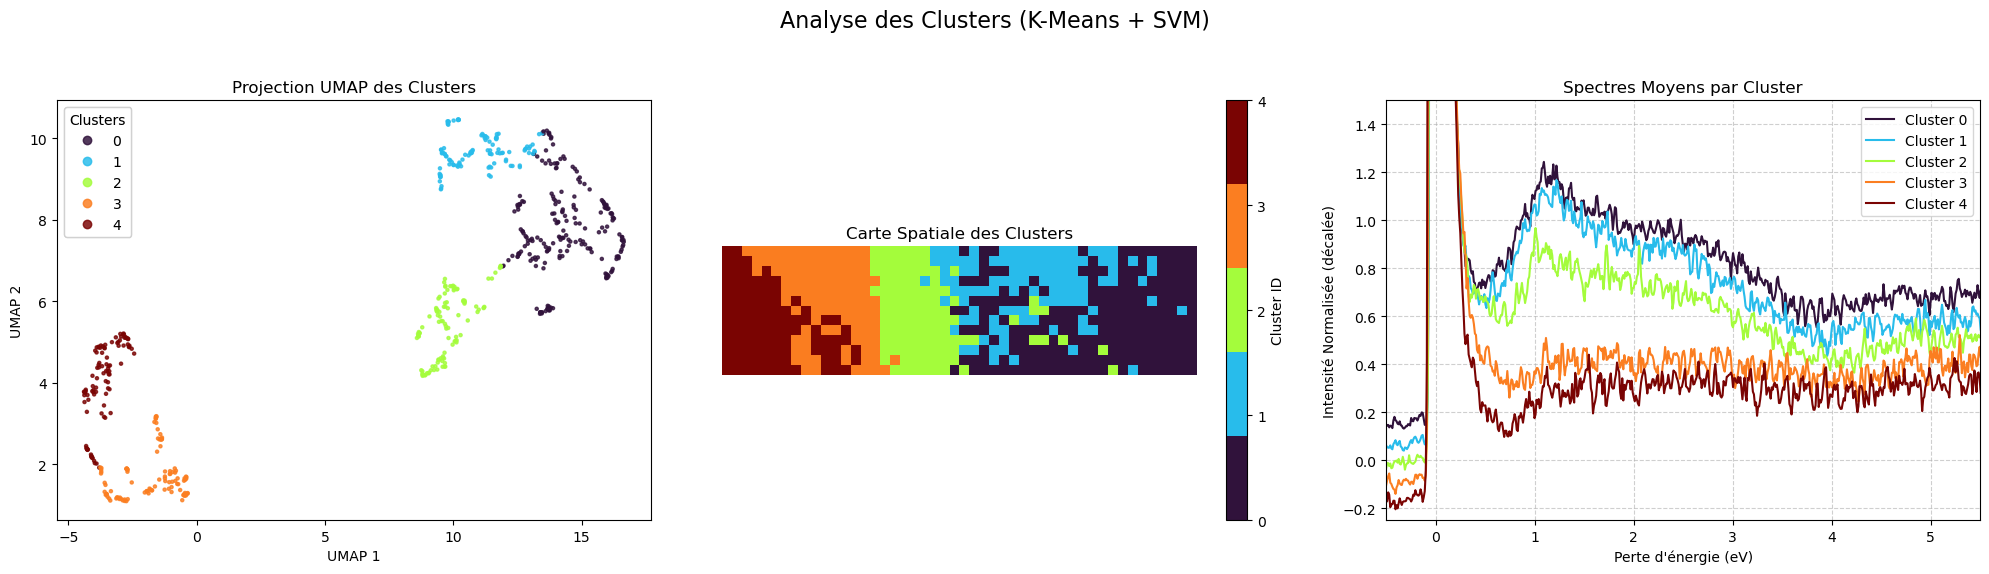

In [14]:
# Diviser les données pour l'entraînement et le test
X_train, X_test, y_train, y_test = train_test_split(
    umap_embedding, kmeans_labels, test_size=0.2, random_state=42, stratify=kmeans_labels
)

print("Entraînement du classificateur SVM...")
svm_classifier = SVC(kernel='rbf', C=0.1, class_weight='balanced', random_state=42)
svm_classifier.fit(X_train, y_train)

# Évaluation de la performance
y_pred = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Précision de la classification SVM : {accuracy * 100:.2f}%')

# Prédiction sur l'ensemble des données pour obtenir les labels raffinés
refined_labels = svm_classifier.predict(umap_embedding)

# Lancer l'analyse pour les labels raffinés par SVM
analyze_and_plot_clusters(refined_labels, "K-Means + SVM")